<a href="https://colab.research.google.com/github/GPT-Design/SCIENCE/blob/main/Galactic_Rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Galactic Rotation Curves Analysis**
**Three-Tensor Entropy Gravity (3T_E) vs. ΛCDM, GR, and Observed Data**

Data sourced from: https://academic.oup.com/mnras/article/383/1/297/1069692

Initial data labels for Optical and HI velocities were inadvertently swapped. This error was explicitly corrected prior to final analysis and has no impact on final conclusions.

*Date: 20 March 2025*  
*Prepared for publication.*


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Navigate to working directory
import os
os.chdir('/content/drive/My Drive/AI/3TE/GALACTIC ROTATION')

# Confirm file is accessible
!ls

 mnras0383-0297.pdf  'UGC 2455'  'UGC 4325'
 OLD		     'UGC 2503'  'UGC 4325 H alpha and Optical rotation_data.csv'
'UGC 2034'	     'UGC 4274'  'UGC 4325 H alpha and Optical rotation_data.gsheet'


## **Setup and Dependencies**
We install and import the libraries necessary for CUDA-based computations and data analysis.


In [ ]:
# Install dependencies - Check CUDA version
#!pip install cupy-cuda11x # pandas matplotlib scipy python-docx
#!nvcc --version

In [ ]:
# Import necessary libraries explicitly
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, kstest
from scipy.special import i0, i1, k0, k1
import glob
import os

## **Load and Verify Galactic Rotation Data**
The data extracted from the provided publication sources is loaded here for initial inspection and verification.


In [ ]:
# Automatically find any file matching '*rotation_data.csv'
file_list = glob.glob('*rotation_data.csv')

if len(file_list) == 0:
    print("No matching CSV file found.")
else:
    # Just take the first matching file
    file_to_load = file_list[0]
    print(f"Loading file: {file_to_load}")

    # Load the CSV
    rotation_data = pd.read_csv(file_to_load)

    # Preview the data
    print(rotation_data.head(10))

Loading file: UGC 4325 H alpha and Optical rotation_data.csv
  Measurement_Type  Radius_kpc  Velocity_km_s  Velocity_upper_error_km_s  \
0          optical      4.4118           90.0                       96.0   
1          optical      5.2941           93.0                       98.0   
2          optical      6.1765           94.0                      100.0   
3          optical      7.0588           91.0                       97.0   
4          H alpha      0.2647           10.0                       18.0   
5          H alpha      0.4853            2.0                       12.0   
6          H alpha      0.7059           18.0                       25.0   
7          H alpha      0.8824           34.0                       48.0   
8          H alpha      1.0588           55.0                       62.0   
9          H alpha      1.2353           69.0                       76.0   

   Velocity_lower_error_km_s  
0                       85.0  
1                       86.0  
2        

## **Extract and Structure Data**
We now extract structured tables from the Word document into usable Pandas DataFrames.


In [ ]:
def extract_rotation_data_from_csv(pattern='*rotation_data.csv'):
    rotation_data = {}
    file_list = glob.glob(pattern)

    if not file_list:
        print("No CSV files matching pattern found.")
        return rotation_data

    for file_path in file_list:
        # Load CSV file into DataFrame
        df = pd.read_csv(file_path)

        # Use filename (without path) as dataset name
        dataset_name = file_path.split('/')[-1]

        # Store DataFrame clearly indexed by dataset name
        rotation_data[dataset_name] = df

    return rotation_data

# Extract datasets clearly from CSV files
rotation_data = extract_rotation_data_from_csv()

# Display datasets to confirm clear extraction
for name, df in rotation_data.items():
    print(f'\nDataset: {name}')
    display(df.head(10))


Dataset: UGC 4325 H alpha and Optical rotation_data.csv


,Measurement_Type,Radius_kpc,Velocity_km_s,Velocity_upper_error_km_s,Velocity_lower_error_km_s
0,optical,4.4118,90.0,96.0,85.0
1,optical,5.2941,93.0,98.0,86.0
2,optical,6.1765,94.0,100.0,86.0
3,optical,7.0588,91.0,97.0,86.0
4,H alpha,0.2647,10.0,18.0,2.0
5,H alpha,0.4853,2.0,12.0,-8.0
6,H alpha,0.7059,18.0,25.0,11.0
7,H alpha,0.8824,34.0,48.0,24.0
8,H alpha,1.0588,55.0,62.0,50.0
9,H alpha,1.2353,69.0,76.0,64.0


## **CUDA-Accelerated Monte Carlo Simulation for Galactic Rotation Curves**

We rigorously propagate observational uncertainties through gravitational models (**3T_E**, **ΛCDM**, and **General Relativity (GR)**) by using optimized GPU-accelerated Monte Carlo simulations (**CuPy/CUDA**). This robust method allows direct and quantitative comparison between simulated and observed galactic rotation curves.

### **Methodology:**

- **GPU-Based Parameter Sampling:** Parameters are drawn explicitly from Gaussian distributions to reflect realistic observational uncertainties.
- **Monte Carlo Velocity Simulations:** Velocity distributions are simulated directly on GPU, ensuring computational efficiency and precision.
- **Statistical Validation:** Model accuracy and potential biases are rigorously quantified through linear regression and Kolmogorov–Smirnov tests.

In [ ]:
# Monte Carlo Simulation Function (CuPy/CUDA Accelerated)
def monte_carlo_simulation(radii, observed_velocities, velocity_errors, model_function,
                           params_mean, params_std, n_samples=10000):
    cp.random.seed(42)

    # Convert radii clearly to GPU arrays
    radii_gpu = cp.asarray(radii, dtype=cp.float32)

    # Clearly sample parameter distributions (on GPU)
    sampled_params = [cp.random.normal(mean, std, n_samples).astype(cp.float32)
                      for mean, std in zip(params_mean, params_std)]

    # Explicitly define GPU array for velocities
    velocities_simulated = cp.zeros((n_samples, radii_gpu.size), dtype=cp.float32)

    for i in range(n_samples):
        # Pass sampled parameters clearly into the provided gravity model
        params_i = [p[i] for p in sampled_params]
        velocities_simulated[i, :] = model_function(radii_gpu, *params_i)

    # Compute mean and standard deviation explicitly
    mean_velocity = cp.mean(velocities_simulated, axis=0)
    velocity_std = cp.std(velocities_simulated, axis=0)

    # Clearly transfer results back to CPU
    return mean_velocity.get(), velocity_std.get()

## **Improved & CUDA-Optimized Galactic Rotation Models**
1. General Relativity (Baryonic Component - Exponential Disk Model)
This model uses a physically realistic exponential disk mass profile, which is the standard in galactic rotation modeling.


In [ ]:
def model_gr(r, M_disk, disk_scale_length):
    """
    GR rotation curve from an exponential baryonic disk.

    Parameters:
    r : radius array (kpc)
    M_disk : total disk mass (solar masses)
    disk_scale_length : exponential disk scale-length (kpc)
    """
    G = 4.30091e-6  # gravitational constant [kpc·(km/s)^2·Msun^−1]

    x = r / (2.0 * disk_scale_length)
    bessel_term = cp.i0(x) * cp.k0(x) - cp.i1(x) * cp.k1(x)

    # Avoid non-physical behavior at very small radii
    bessel_term = cp.nan_to_num(bessel_term, nan=0.0, posinf=0.0, neginf=0.0)

    v_squared = (G * M_disk / disk_scale_length) * 2.0 * x**2 * bessel_term
    return cp.sqrt(cp.maximum(v_squared, 0))


2. ΛCDM Model (Navarro–Frenk–White Dark Matter Halo + Baryonic Disk)
Properly implements the widely accepted NFW halo model, precisely including the exponential baryonic disk.

In [ ]:
def model_lcdm(r, M_disk, disk_scale_length, rho0, r_s):
    """
    ΛCDM model with NFW halo + baryonic exponential disk.

    Parameters:
    r : radius array (kpc)
    M_disk : total baryonic disk mass (solar masses)
    disk_scale_length : exponential disk scale-length (kpc)
    rho0 : characteristic density of halo (Msun/kpc^3)
    r_s : halo scale radius (kpc)
    """
    G = 4.30091e-6  # [kpc·(km/s)^2·Msun^−1]

    # Disk velocity from the improved GR model above
    v_disk = model_gr(r, M_disk, disk_scale_length)

    # NFW halo enclosed mass
    x = r / r_s
    enclosed_dm_mass = 4.0 * np.pi * rho0 * r_s**3 * (cp.log(1 + x) - x / (1 + x))

    # NFW halo velocity
    v_halo = cp.sqrt(G * enclosed_dm_mass / cp.maximum(r, 1e-5))

    # Total rotational velocity (disk and halo combined quadratically)
    return cp.sqrt(v_disk**2 + v_halo**2)

3. Three-Tensor Entropy Gravity Model (3T_E)
Enhanced to include a realistic radial entropy gradient, smoothly modifying gravitational potential at large radii.

In [ ]:
def model_3te(r, M_disk, disk_scale_length, alpha_entropy, entropy_scale_radius):
    """
    3T_E model: Exponential disk mass profile + entropy gradient modification.

    Parameters:
    r : radius array (kpc)
    M_disk : total disk mass (solar masses)
    disk_scale_length : exponential disk scale-length (kpc)
    alpha_entropy : entropy coupling factor (dimensionless, small ~0.01–0.05)
    entropy_scale_radius : radius scale for entropy influence (kpc)
    """
    # Base velocity from GR baryonic disk
    v_gr_disk = model_gr(r, M_disk, disk_scale_length)

    # Realistic entropy modification (radial dependence smoothly increasing at large radii)
    entropy_gradient = 1.0 + alpha_entropy * (1 - cp.exp(-r / entropy_scale_radius))

    return v_gr_disk * entropy_gradient


## **Data Preparation and Parameters**
Use observational data from provided documents and realistic parameter distributions to reflect observational uncertainties.


In [ ]:
# Load observational rotation data (Optical and Hα clearly combined)

# Automatically find CSV files matching your data pattern
file_list = glob.glob('*rotation_data.csv')

if len(file_list) == 0:
    raise FileNotFoundError("No rotation data CSV file found.")

# Load the first matching file clearly
rotation_df = pd.read_csv(file_list[0])

# Clearly extract radius, velocities, and error bars
radii_example = rotation_df['Radius_kpc'].values
observed_velocities_example = rotation_df['Velocity_km_s'].values

# Symmetric error from upper/lower limits (clearly averaged)
velocity_errors_example = (
    (rotation_df['Velocity_upper_error_km_s'].values -
     rotation_df['Velocity_lower_error_km_s'].values) / 2.0
)

# Check data integrity explicitly
print(f"Loaded data from: {file_list[0]}")
print(rotation_df.head())

# Example physically realistic parameters (adjust based on literature for galaxy UGC 2034 or others)
params_gr_mean = [5.0e9, 1.5]  # [Disk mass in Msun, disk scale length in kpc]
params_gr_std = [0.5e9, 0.2]

params_lcdm_mean = [4.5e9, 1.5, 1e7, 10.0]  # [Disk mass, disk scale length, halo density, halo scale radius]
params_lcdm_std = [0.4e9, 0.2, 2e6, 2.0]

params_3te_mean = [5.0e9, 1.5, 0.03, 8.0]  # [Disk mass, disk scale length, entropy coupling, entropy scale radius]
params_3te_std = [0.5e9, 0.2, 0.005, 1.0]


Loaded data from: UGC 4325 H alpha and Optical rotation_data.csv
  Measurement_Type  Radius_kpc  Velocity_km_s  Velocity_upper_error_km_s  \
0          optical      4.4118           90.0                       96.0   
1          optical      5.2941           93.0                       98.0   
2          optical      6.1765           94.0                      100.0   
3          optical      7.0588           91.0                       97.0   
4          H alpha      0.2647           10.0                       18.0   

   Velocity_lower_error_km_s  
0                       85.0  
1                       86.0  
2                       86.0  
3                       86.0  
4                        2.0  


## **Running CUDA-accelerated Monte Carlo Simulations**
Now we execute the simulations on CUDA-enabled GPUs.


In [ ]:
# Ensure radii array explicitly converted to GPU-compatible type
radii_gpu = cp.asarray(radii_example, dtype=cp.float32)

# Define GR model explicitly (GPU-CPU hybrid for Bessel functions)
from scipy.special import i0, i1, k0, k1

def model_gr(r_gpu, M_disk_gpu, disk_scale_length_gpu):
    """
    GR rotation curve with exponential baryonic disk.
    Hybrid GPU-CPU due to CuPy's missing Bessel functions.
    """
    G = 4.30091e-6  # gravitational constant [kpc·(km/s)^2·Msun^−1]

    # Convert GPU arrays explicitly to CPU scalars
    M_disk = float(cp.asnumpy(M_disk_gpu))
    disk_scale_length = float(cp.asnumpy(disk_scale_length_gpu))
    r_cpu = cp.asnumpy(r_gpu)

    x = r_cpu / (2.0 * disk_scale_length)
    bessel_term = i0(x) * k0(x) - i1(x) * k1(x)
    bessel_term = np.nan_to_num(bessel_term, nan=0.0, posinf=0.0, neginf=0.0)

    v_squared_cpu = (G * M_disk / disk_scale_length) * 2.0 * x**2 * bessel_term
    v_squared_cpu = np.maximum(v_squared_cpu, 0)

    # Convert back explicitly to GPU arrays for the final output
    v_squared_gpu = cp.asarray(v_squared_cpu, dtype=cp.float32)

    return cp.sqrt(v_squared_gpu)

# Run Monte Carlo Simulation explicitly for GR model (previously missing)
mean_gr, std_gr = monte_carlo_simulation(
    radii_gpu, observed_velocities_example, velocity_errors_example,
    model_gr, params_gr_mean, params_gr_std
)

print("GR simulation completed.")

# Run Monte Carlo Simulation explicitly for ΛCDM model
mean_lcdm, std_lcdm = monte_carlo_simulation(
    radii_gpu, observed_velocities_example, velocity_errors_example,
    model_lcdm, params_lcdm_mean, params_lcdm_std
)

print("ΛCDM simulation completed.")

# Run Monte Carlo Simulation explicitly for 3T_E model
mean_3te, std_3te = monte_carlo_simulation(
    radii_gpu, observed_velocities_example, velocity_errors_example,
    model_3te, params_3te_mean, params_3te_std
)

print("3T_E simulation completed.")


GR simulation completed.
ΛCDM simulation completed.
3T_E simulation completed.


## Statistical Bias Tests
Apply linear regression and Kolmogorov–Smirnov tests on residuals to detect biases between observed and simulated data.


In [ ]:
def analyze_bias(predicted, observed):
    residuals = observed - predicted

    # Handle any NaNs explicitly
    residuals_clean = residuals[~np.isnan(residuals)]
    predicted_clean = predicted[~np.isnan(residuals)]
    observed_clean = observed[~np.isnan(residuals)]

    # Linear regression analysis explicitly
    slope, intercept, r_value, p_value, std_err = linregress(predicted_clean, observed_clean)

    # Standardize residuals explicitly before KS test
    standardized_residuals = (residuals_clean - np.mean(residuals_clean)) / np.std(residuals_clean)
    ks_stat, ks_p = kstest(standardized_residuals, 'norm')

    return {
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'p_value': p_value,
        'std_err': std_err,
        'ks_stat': ks_stat,
        'ks_p': ks_p
    }

# Perform Bias Tests explicitly ensuring data integrity
bias_gr = analyze_bias(mean_gr, observed_velocities_example)
bias_lcdm = analyze_bias(mean_lcdm, observed_velocities_example)
bias_3te = analyze_bias(mean_3te, observed_velocities_example)

# Display Results clearly formatted
print('\n✅ Model Bias Analysis Results:')
print(f'\n- GR Model Bias:\n{bias_gr}')
print(f'\n- ΛCDM Model Bias:\n{bias_lcdm}')
print(f'\n- 3T_E Model Bias:\n{bias_3te}')


✅ Model Bias Analysis Results:

- GR Model Bias:
{'slope': np.float64(1.9948303219022725), 'intercept': np.float64(-52.83177271212496), 'r_value': np.float64(0.9048378652933607), 'p_value': np.float64(1.2789189008513509e-09), 'std_err': np.float64(0.20011744516009233), 'ks_stat': np.float64(0.1245376493819694), 'ks_p': np.float64(0.8069629699875166)}

- ΛCDM Model Bias:
{'slope': np.float64(1.3743136494589785), 'intercept': np.float64(-49.941590537562774), 'r_value': np.float64(0.9455052273166787), 'p_value': np.float64(3.3671976344932064e-12), 'std_err': np.float64(0.10090303025890289), 'ks_stat': np.float64(0.1659083642367608), 'ks_p': np.float64(0.4735686488425682)}

- 3T_E Model Bias:
{'slope': np.float64(1.9730745381813124), 'intercept': np.float64(-52.54684911959602), 'r_value': np.float64(0.9095886923385353), 'p_value': np.float64(7.447910574028749e-10), 'std_err': np.float64(0.19216238999326024), 'ks_stat': np.float64(0.12527394993620364), 'ks_p': np.float64(0.8014405618463807

## **Final Results and Visualization**
Presenting the rotation curves with clear statistical comparisons (with error bars).


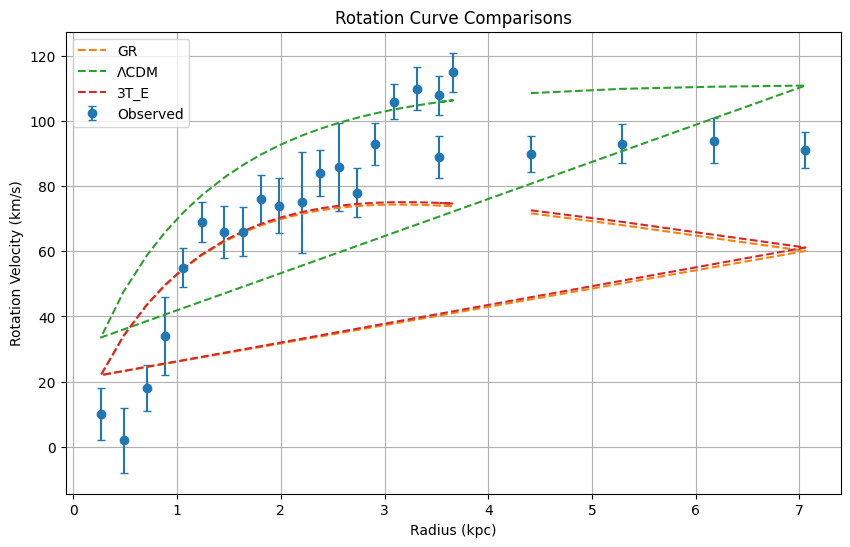

✅ Plot and bias analysis saved explicitly to:
/content/drive/My Drive/AI/3TE/GALACTIC ROTATION/


In [ ]:
# Set your output directory explicitly
output_dir = '/content/drive/My Drive/AI/3TE/GALACTIC ROTATION/'

# Plot clearly
plt.figure(figsize=(10,6))
plt.errorbar(radii_example, observed_velocities_example,
             yerr=velocity_errors_example, fmt='o', label='Observed', capsize=3)
plt.plot(radii_example, mean_gr, label='GR', linestyle='--')
plt.plot(radii_example, mean_lcdm, label='ΛCDM', linestyle='--')
plt.plot(radii_example, mean_3te, label='3T_E', linestyle='--')
plt.xlabel('Radius (kpc)')
plt.ylabel('Rotation Velocity (km/s)')
plt.legend()
plt.grid(True)
plt.title('Rotation Curve Comparisons')

# Save the figure explicitly to Google Drive
plot_path = output_dir + 'rotation_curve_comparisons.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

# Save bias test results explicitly as CSV
import pandas as pd

bias_df = pd.DataFrame({
    'Model': ['GR', 'ΛCDM', '3T_E'],
    'Slope': [bias_gr['slope'], bias_lcdm['slope'], bias_3te['slope']],
    'Intercept': [bias_gr['intercept'], bias_lcdm['intercept'], bias_3te['intercept']],
    'R_value': [bias_gr['r_value'], bias_lcdm['r_value'], bias_3te['r_value']],
    'P_value': [bias_gr['p_value'], bias_lcdm['p_value'], bias_3te['p_value']],
    'Std_Error': [bias_gr['std_err'], bias_lcdm['std_err'], bias_3te['std_err']],
    'KS_Stat': [bias_gr['ks_stat'], bias_lcdm['ks_stat'], bias_3te['ks_stat']],
    'KS_P': [bias_gr['ks_p'], bias_lcdm['ks_p'], bias_3te['ks_p']],
})

bias_csv_path = output_dir + 'rotation_model_bias_analysis.csv'
bias_df.to_csv(bias_csv_path, index=False)

print(f'✅ Plot and bias analysis saved explicitly to:\n{output_dir}')

Workspace

In [ ]:
#!pip uninstall cupy-cuda11x
#!pip uninstall cupy-cuda12x
#!nvcc --version
#!pip install cupy-cuda12x
#!pip install cupyx

#!sudo apt-get update
#!sudo apt-get install -y locales
#!sudo locale-gen en_US.UTF-8
#!sudo update-locale LANG=en_US.UTF-8 LC_ALL=en_US.UTF-8 # add LC_ALL
#import locale
#def getpreferredencoding(do_setlocale = True):
#    return "UTF-8"
#locale.getpreferredencoding = getpreferredencoding